In [1]:
# Importing required libraries 
# Keras
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow.keras.utils as utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

import time

# start_time = time.time()
# print(f"--- {time.time() - start_time} seconds ---")

In [2]:
ref = pd.read_csv('RAVDESS_dataframe.csv')
ref.head()

,gender,emotion,labels,path
0,male,angry,male_angry,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-05...
1,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...
2,male,disgust,male_disgust,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-07...
3,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...
4,male,surprise,male_surprise,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-08...


In [3]:
start_time = time.time()


# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=48000
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))




print(f"--- {time.time() - start_time} seconds ---")

df.head()

1440
--- 35.96572685241699 seconds ---


,feature
0,"[-55.61269, -56.2771, -56.28026, -54.96154, -5..."
1,"[-71.47245, -71.47245, -71.10964, -68.89937, -..."
2,"[-69.44611, -69.44611, -69.44611, -69.44611, -..."
3,"[-69.90503, -69.86861, -69.90503, -69.90503, -..."
4,"[-64.84805, -64.84805, -64.84805, -64.84805, -..."


In [4]:
df_processed = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_processed[:5]

,gender,emotion,labels,path,0,1,2,3,4,5,...,225,226,227,228,229,230,231,232,233,234
0,male,angry,male_angry,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-05...,-55.612690,-56.277100,-56.280258,-54.961540,-54.760498,-56.270699,...,-56.281174,-56.281174,-56.281174,-56.010765,-56.228943,-56.281174,-56.281174,-56.281174,-56.281174,-56.281174
1,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...,-71.472450,-71.472450,-71.109642,-68.899368,-71.406387,-71.472450,...,-30.753172,-31.356428,-33.237289,-36.219086,-40.019844,-39.284313,-41.995590,-39.923244,-41.920223,-44.674606
2,male,disgust,male_disgust,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-07...,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,...,-34.327042,-33.364403,-34.830746,-37.748177,-38.264187,-38.390324,-39.573997,-41.444107,-42.311619,-44.731667
3,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...,-69.905029,-69.868607,-69.905029,-69.905029,-69.905029,-69.905029,...,-61.936401,-59.778069,-62.469486,-63.688515,-64.990250,-60.271835,-57.834335,-59.412334,-63.083355,-61.245667
4,male,surprise,male_surprise,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-08...,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,...,-62.991230,-64.679863,-64.848053,-64.848053,-64.768166,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053


In [5]:
# replace NA with 0
df_processed=df_processed.fillna(0)
print(df.shape)
df[:5]

(1440, 1)


,feature
0,"[-55.61269, -56.2771, -56.28026, -54.96154, -5..."
1,"[-71.47245, -71.47245, -71.10964, -68.89937, -..."
2,"[-69.44611, -69.44611, -69.44611, -69.44611, -..."
3,"[-69.90503, -69.86861, -69.90503, -69.90503, -..."
4,"[-64.84805, -64.84805, -64.84805, -64.84805, -..."


## Splitting dataset: Training and validation:

In [6]:
df_processed.drop(['path','labels','gender','emotion'], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
0,-55.612690,-56.277100,-56.280258,-54.961540,-54.760498,-56.270699,-56.281174,-56.281174,-56.281174,-56.281174,...,-56.281174,-56.281174,-56.281174,-56.010765,-56.228943,-56.281174,-56.281174,-56.281174,-56.281174,-56.281174
1,-71.472450,-71.472450,-71.109642,-68.899368,-71.406387,-71.472450,-71.472450,-71.472450,-71.472450,-71.472450,...,-30.753172,-31.356428,-33.237289,-36.219086,-40.019844,-39.284313,-41.995590,-39.923244,-41.920223,-44.674606
2,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,-69.446114,...,-34.327042,-33.364403,-34.830746,-37.748177,-38.264187,-38.390324,-39.573997,-41.444107,-42.311619,-44.731667
3,-69.905029,-69.868607,-69.905029,-69.905029,-69.905029,-69.905029,-69.905029,-69.905029,-69.905029,-69.905029,...,-61.936401,-59.778069,-62.469486,-63.688515,-64.990250,-60.271835,-57.834335,-59.412334,-63.083355,-61.245667
4,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053,...,-62.991230,-64.679863,-64.848053,-64.848053,-64.768166,-64.848053,-64.848053,-64.848053,-64.848053,-64.848053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-64.830612,-64.830612,-64.830612,-64.830612,-64.830612,-64.830612,-64.830612,-64.830612,-64.830612,-64.830612,...,-64.825241,-64.087883,-64.580177,-63.686932,-61.888149,-62.901615,-63.547104,-62.853157,-63.306709,-63.028633
1436,-64.371292,-64.371292,-64.371292,-64.605408,-65.461617,-65.182602,-64.857437,-66.060318,-65.262589,-66.383400,...,-59.846638,-60.330479,-61.403244,-60.865337,-60.773865,-60.357029,-62.438786,-64.238052,-64.397881,-64.372169
1437,-45.822014,-45.822014,-45.822014,-45.822014,-45.822014,-45.822014,-45.822014,-45.822014,-45.822014,-45.822014,...,-42.840157,-44.573303,-46.007793,-44.717552,-44.155876,-44.333450,-42.896072,-43.935940,-44.745132,-44.851601
1438,-57.300686,-57.300686,-57.300686,-57.300686,-57.300686,-57.300686,-57.470200,-57.377659,-57.300686,-57.320000,...,-43.059505,-44.832989,-44.479885,-44.765240,-44.265144,-47.719749,-48.577980,-51.516617,-51.590557,-51.073380


In [7]:
df_processed.labels

0            male_angry
1          male_neutral
2          male_disgust
3          male_neutral
4         male_surprise
             ...       
1435       female_happy
1436     female_neutral
1437        female_fear
1438    female_surprise
1439     female_disgust
Name: labels, Length: 1440, dtype: object

In [8]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df_processed.drop(['path','labels','gender','emotion'], axis=1),
                                                        df_processed.labels,
                                                        test_size=0.25,
                                                        shuffle=True,
                                                        random_state=42,
                                                   )

# Lets see how the data present itself before normalisation 
print(f'Train data shape: {X_train.shape}\nValid data shape: {X_test.shape}')

Train data shape: (1080, 235)
Valid data shape: (360, 235)


## Normalising data:

In [9]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

In [10]:
mean.shape

(235,)

In [11]:
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [12]:
X_train.iloc[0]

0      2.203534
1      2.228509
2      1.795305
3      1.529539
4      1.523704
         ...   
230   -0.025173
231   -0.024894
232    0.009569
233   -0.029304
234   -0.090792
Name: 296, Length: 235, dtype: float64

In [13]:
df_processed.drop(['path','labels','gender','emotion'], axis=1).loc[50]

0     -68.508186
1     -68.620560
2     -67.852554
3     -65.889267
4     -68.185295
         ...    
230   -58.912666
231   -60.937706
232   -68.472267
233   -68.508186
234   -68.508186
Name: 50, Length: 235, dtype: float64

In [14]:
X_train.shape

(1080, 235)

In [15]:
y_train

296         male_fear
1065     female_angry
1219     male_neutral
1283      female_fear
286        male_happy
            ...      
1095     male_disgust
1130    male_surprise
1294       female_sad
860         male_fear
1126     male_neutral
Name: labels, Length: 1080, dtype: object

In [16]:
y_train.shape

(1080,)

In [17]:
y_test

168       male_disgust
605         male_angry
548       female_angry
65         female_fear
628       male_neutral
             ...      
100     female_neutral
382      male_surprise
618          male_fear
915     female_disgust
1193    female_neutral
Name: labels, Length: 360, dtype: object

In [18]:
y_test.shape

(360,)

In [19]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [20]:
X_test.shape

(360, 235)

In [21]:
# one hot encode the target 
lb = LabelEncoder()
y_train = utils.to_categorical(lb.fit_transform(y_train))
y_test = utils.to_categorical(lb.fit_transform(y_test))

In [22]:
y_test.shape

(360, 14)

In [23]:
print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

(1080, 235)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [24]:
# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [25]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 235, 1)

## Modelling

In [44]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 235, 256)          2304      
_________________________________________________________________
activation_9 (Activation)    (None, 235, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 235, 256)          524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 235, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 235, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 29, 256)          

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
68/68 [==============================] - 12s 179ms/step - loss: 2.4069 - accuracy: 0.2074 - val_loss: 2.6300 - val_accuracy: 0.1111
Epoch 2/20
68/68 [==============================] - 12s 178ms/step - loss: 2.1065 - accuracy: 0.2787 - val_loss: 2.6064 - val_accuracy: 0.1111
Epoch 3/20
68/68 [==============================] - 12s 178ms/step - loss: 1.9151 - accuracy: 0.3315 - val_loss: 2.5664 - val_accuracy: 0.1111
Epoch 4/20
68/68 [==============================] - 12s 177ms/step - loss: 1.7701 - accuracy: 0.3667 - val_loss: 2.4951 - val_accuracy: 0.1556
Epoch 5/20
68/68 [==============================] - 13s 185ms/step - loss: 1.6428 - accuracy: 0.4213 - val_loss: 2.4086 - val_accuracy: 0.1722
Epoch 6/20
68/68 [==============================] - 13s 194ms/step - loss: 1.5245 - accuracy: 0.4750 - val_loss: 2.2682 - val_accuracy: 0.2194
Epoch 7/20
68/68 [==============================] - 13s 194ms/step - loss: 1.4166 - accuracy: 0.5287 - val_loss: 2.0505 - val_accuracy: 0.3222

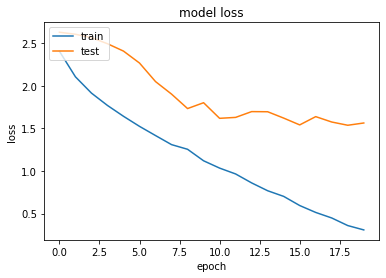

In [46]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /mnt/4ad2bea6-cc88-45e6-80b1-ea29034f180c/Documentos/workspace/LabInter/AEmotion_CNN/saved_models/Emotion_Model.h5 


In [48]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser

opt = keras.optimizers.Adam(lr=0.001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 47.78%


In [49]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

23/23 [==============================] - 1s 34ms/step


array([ 8,  8, 10,  2, 10,  8,  5,  0,  2,  8,  4,  2, 11,  0, 10,  3,  4,
       10,  4,  2,  4,  3,  4,  8,  2, 13,  7,  4, 11, 10,  8,  8, 10,  7,
        8, 11, 11,  8, 10, 12,  5,  7,  0, 12, 11, 13,  5,  7,  6,  4, 10,
       10,  9,  4,  2,  2,  3,  2,  7,  9, 11,  0, 10,  3,  0,  0,  5,  1,
        4, 11,  2,  4,  5,  6,  8,  7, 13,  4,  7,  4, 11,  2, 10,  3,  5,
        7,  9,  3, 12,  4,  4,  1,  3,  3,  1, 11,  5, 11,  6, 11,  4, 11,
       11, 10,  8,  4,  6,  3,  8,  7,  3,  4, 10,  8,  0,  4, 10, 11,  7,
        0,  3,  4,  4, 10, 10, 10,  4,  8, 10,  2, 11,  7, 10, 12,  2, 13,
        3, 12,  3,  3,  8,  7,  4, 10,  8, 13, 12, 11,  7,  4,  9,  5,  4,
        7,  2, 10,  4, 12,  8,  1, 11,  7,  9,  5,  2,  4, 10,  3,  0,  6,
        3, 10,  3,  0,  7,  3, 11, 11, 10,  4,  6,  5,  4, 10,  2, 11,  0,
        0,  1, 10, 11,  0,  4,  5, 11,  6, 11,  0,  5,  4, 10, 12, 12,  3,
       12,  4, 13,  5,  0, 11,  1, 11,  4,  2,  0, 12,  3,  5,  4, 11,  5,
       10,  2,  6, 10,  6

In [50]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_sad,female_happy
171,male_disgust,male_happy
172,female_happy,female_happy
173,female_angry,female_angry
174,male_angry,male_angry
175,female_surprise,female_happy
176,male_neutral,male_neutral
177,male_neutral,male_neutral
178,male_happy,male_happy
179,female_neutral,female_neutral


In [51]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,27
female_disgust,9
female_fear,26
female_happy,29
female_neutral,51
female_sad,30
female_surprise,17
male_angry,26
male_disgust,24


In [52]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


0.4777777777777778


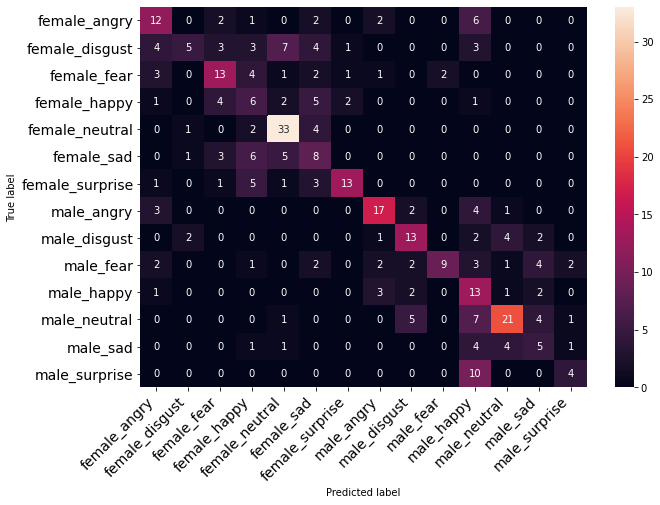

In [53]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [54]:
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.44      0.48      0.46        25
 female_disgust       0.56      0.17      0.26        30
    female_fear       0.50      0.48      0.49        27
   female_happy       0.21      0.29      0.24        21
 female_neutral       0.65      0.82      0.73        40
     female_sad       0.27      0.35      0.30        23
female_surprise       0.76      0.54      0.63        24
     male_angry       0.65      0.63      0.64        27
   male_disgust       0.54      0.54      0.54        24
      male_fear       0.82      0.32      0.46        28
     male_happy       0.25      0.59      0.35        22
   male_neutral       0.66      0.54      0.59        39
       male_sad       0.29      0.31      0.30        16
  male_surprise       0.50      0.29      0.36        14

       accuracy                           0.48       360
      macro avg       0.51      0.45      0.45       360
   weighted avg       0.53   

In [36]:
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.24      0.56      0.34        25
 female_disgust       0.33      0.03      0.06        30
    female_fear       0.00      0.00      0.00        27
   female_happy       0.24      0.38      0.30        21
 female_neutral       0.49      0.85      0.62        40
     female_sad       1.00      0.09      0.16        23
female_surprise       0.29      0.21      0.24        24
     male_angry       0.43      0.70      0.54        27
   male_disgust       0.30      0.12      0.18        24
      male_fear       0.00      0.00      0.00        28
     male_happy       0.06      0.05      0.05        22
   male_neutral       0.38      0.92      0.54        39
       male_sad       0.38      0.19      0.25        16
  male_surprise       0.00      0.00      0.00        14

       accuracy                           0.35       360
      macro avg       0.30      0.29      0.23       360
   weighted avg       0.31   

/home/tuliochiodi/miniconda3/envs/AEmotion/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
